# Abstract

This notebook uses the pCTR predictions of the three models and implemets a function to evaluate their performance on the validation set using the Linear Strategy. In addition, we tune the base_bid parameter to optimize performance.

# Import data

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

In [2]:
train = pd.read_csv("train.csv")
validation = pd.read_csv("validation.csv")

In [3]:
print(train.shape, validation.shape)

(2430981, 25) (303925, 25)


# Import Predictions

In [4]:
lr_preds = pd.read_csv("Prediction_csv/lr_pCTR.csv", index_col  = "Unnamed: 0")
rf_preds = pd.read_csv("Prediction_csv/rf_pCTR.csv", index_col  = "Unnamed: 0")
xgb_preds = pd.read_csv("Prediction_csv/xgb_pCTR.csv", index_col  = "Unnamed: 0")

In [5]:
base_bid = train.loc[ train["click"] == 1, "payprice"].mean()
basebid_max = train.loc[ train["click"] == 1, "payprice"].max()
basebid_min = train.loc[ train["click"] == 1, "payprice"].min()
avgCTR = train["click"].sum()*100/train.shape[0]

In [6]:
print("Base bid: {}, \nMax basebid: {} \nMin basebid: {} \navgCTR: {}".format(base_bid, 
                                                                                   basebid_max,
                                                                                   basebid_min,
                                                                                   avgCTR))

Base bid: 105.46402677077523, 
Max basebid: 300 
Min basebid: 4 
avgCTR: 0.07375623256619447


In [7]:
basebids = np.linspace(0.2*base_bid, 6*base_bid, 100)
basebids

array([ 21.09280535,  27.27150591,  33.45020647,  39.62890703,
        45.80760759,  51.98630815,  58.1650087 ,  64.34370926,
        70.52240982,  76.70111038,  82.87981094,  89.0585115 ,
        95.23721205, 101.41591261, 107.59461317, 113.77331373,
       119.95201429, 126.13071485, 132.3094154 , 138.48811596,
       144.66681652, 150.84551708, 157.02421764, 163.20291819,
       169.38161875, 175.56031931, 181.73901987, 187.91772043,
       194.09642099, 200.27512154, 206.4538221 , 212.63252266,
       218.81122322, 224.98992378, 231.16862434, 237.34732489,
       243.52602545, 249.70472601, 255.88342657, 262.06212713,
       268.24082769, 274.41952824, 280.5982288 , 286.77692936,
       292.95562992, 299.13433048, 305.31303104, 311.49173159,
       317.67043215, 323.84913271, 330.02783327, 336.20653383,
       342.38523439, 348.56393494, 354.7426355 , 360.92133606,
       367.10003662, 373.27873718, 379.45743773, 385.63613829,
       391.81483885, 397.99353941, 404.17223997, 410.35

# Linear Strategy

In [8]:
def LinearStrategy(sub_pCTR, sub_basebid):
    
    avgCTR = sub_pCTR["click_proba"].mean()
    bidprice = (sub_pCTR["click_proba"] * sub_basebid) / avgCTR
    return bidprice

# Evaluate Results

In [9]:
budget = 6250*1000

def ValidationDataFrame(submission_pCTR, submission_basebid):
    
    validation_check = validation[["bidid", "click", "bidprice", "payprice"]]
    validation_check["click_proba"] = submission_pCTR["click_proba"]
    validation_check["bidprice_predicted"] = LinearStrategy(submission_pCTR, submission_basebid)
    
    return validation_check


def ValidateStrategy(df):
    
    impressions = 0
    clicks = 0
    cost = 0
    auctions_participated = 0
    balance = budget
    
    for row in df.iterrows():
        
        if cost < budget:
            
            auctions_participated+=1
            
            if (row[1]["bidprice_predicted"] >= row[1]["payprice"]):
                
                if (balance > row[1]["bidprice_predicted"]):
                    
                    impressions+=1
                    clicks+=row[1]["click"]
                    cost+=row[1]["payprice"]
                    balance-=row[1]["payprice"]
                else:
                    pass
    
        else:
            break
    
    # Metrics
    ctr = clicks*100/impressions
    cpm = cost/impressions
    cpc = cost/clicks/1000
    
    print("Strategy statistics:")
    print("Auctions participated: {} | Impressions: {} | Clicks: {} | Cost: {} | CTR: {} | CPM: {} | CPC: {}".format(auctions_participated, \
                                                                                                                     impressions, clicks, \
                                                                                                                     cost,\
                                                                                                                     np.round(ctr,5), \
                                                                                                                     np.round(cpm,5), \
                                                                                                                     np.round(cpc,2)))
    print("\n")
            
    return impressions, clicks, cost, auctions_participated, ctr, cpm, cpc

In [10]:
pCTR_preds = [lr_preds, rf_preds, xgb_preds]
pCTR_model_names = ["Logistic Regression", "Random Forest", "XGBoost"]
results = pd.DataFrame(columns = ["pCTR_model", "basebid", "Coefficient", "Impressions", "Clicks", "Cost", "CTR", "CPM", "CPC"])
i=0
k=0

start = time.time()

for pCTR_pred in pCTR_preds:
    for basebid_pred in basebids:
        
        # Strategy 1
        validation_check = ValidationDataFrame(pCTR_pred, basebid_pred)
        print("\033[1m pCTR model: {} \033[0m, \033[1m basebid price: {} \033[0m, \033[1m Coefficient: {} \033[0m ".format(pCTR_model_names[i], basebid_pred, basebid_pred/base_bid))
        impressions, clicks, cost, auctions_participated, ctr, cpm, cpc = ValidateStrategy(validation_check)
        results.loc[k] = [pCTR_model_names[i], basebid_pred, basebid_pred/base_bid, impressions, clicks, cost, ctr, cpm, cpc]
        k+=1           
    i+=1
    
end = time.time()
print("Total time: {} mins".format((end-start)/60))

 pCTR model: Logistic Regression ,  basebid price: 21.092805354155047 ,  Coefficient: 0.2  
Strategy statistics:
Auctions participated: 303925 | Impressions: 45149 | Clicks: 15 | Cost: 608580 | CTR: 0.03322 | CPM: 13.47937 | CPC: 40.57


 pCTR model: Logistic Regression ,  basebid price: 27.271505912442887 ,  Coefficient: 0.2585858585858586  
Strategy statistics:
Auctions participated: 303925 | Impressions: 63286 | Clicks: 21 | Cost: 1022724 | CTR: 0.03318 | CPM: 16.16035 | CPC: 48.7


 pCTR model: Logistic Regression ,  basebid price: 33.45020647073073 ,  Coefficient: 0.31717171717171716  
Strategy statistics:
Auctions participated: 303925 | Impressions: 75227 | Clicks: 34 | Cost: 1392318 | CTR: 0.0452 | CPM: 18.50822 | CPC: 40.95


 pCTR model: Logistic Regression ,  basebid price: 39.62890702901857 ,  Coefficient: 0.37575757575757573  
Strategy statistics:
Auctions participated: 303925 | Impressions: 87133 | Clicks: 45 | Cost: 1829222 | CTR: 0.05165 | CPM: 20.99345 | CPC: 40.65


 p

Strategy statistics:
Auctions participated: 303925 | Impressions: 89973 | Clicks: 58 | Cost: 6249868 | CTR: 0.06446 | CPM: 69.46382 | CPC: 107.76


 pCTR model: Logistic Regression ,  basebid price: 212.63252266107813 ,  Coefficient: 2.016161616161616  
Strategy statistics:
Auctions participated: 303925 | Impressions: 88941 | Clicks: 57 | Cost: 6249821 | CTR: 0.06409 | CPM: 70.26929 | CPC: 109.65


 pCTR model: Logistic Regression ,  basebid price: 218.81122321936596 ,  Coefficient: 2.0747474747474746  
Strategy statistics:
Auctions participated: 303925 | Impressions: 87861 | Clicks: 57 | Cost: 6249854 | CTR: 0.06488 | CPM: 71.13343 | CPC: 109.65


 pCTR model: Logistic Regression ,  basebid price: 224.9899237776538 ,  Coefficient: 2.133333333333333  
Strategy statistics:
Auctions participated: 303925 | Impressions: 86712 | Clicks: 55 | Cost: 6249877 | CTR: 0.06343 | CPM: 72.07626 | CPC: 113.63


 pCTR model: Logistic Regression ,  basebid price: 231.16862433594164 ,  Coefficient: 2.19

Strategy statistics:
Auctions participated: 303925 | Impressions: 79696 | Clicks: 51 | Cost: 6249681 | CTR: 0.06399 | CPM: 78.419 | CPC: 122.54


 pCTR model: Logistic Regression ,  basebid price: 397.9935394097133 ,  Coefficient: 3.7737373737373727  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79696 | Clicks: 51 | Cost: 6249681 | CTR: 0.06399 | CPM: 78.419 | CPC: 122.54


 pCTR model: Logistic Regression ,  basebid price: 404.17223996800124 ,  Coefficient: 3.8323232323232324  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79696 | Clicks: 51 | Cost: 6249681 | CTR: 0.06399 | CPM: 78.419 | CPC: 122.54


 pCTR model: Logistic Regression ,  basebid price: 410.35094052628904 ,  Coefficient: 3.89090909090909  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79696 | Clicks: 51 | Cost: 6249681 | CTR: 0.06399 | CPM: 78.419 | CPC: 122.54


 pCTR model: Logistic Regression ,  basebid price: 416.52964108457684 ,  Coefficient: 3.9494949494

Strategy statistics:
Auctions participated: 303925 | Impressions: 79695 | Clicks: 51 | Cost: 6249611 | CTR: 0.06399 | CPM: 78.41911 | CPC: 122.54


 pCTR model: Logistic Regression ,  basebid price: 583.3545561583486 ,  Coefficient: 5.531313131313131  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79695 | Clicks: 51 | Cost: 6249611 | CTR: 0.06399 | CPM: 78.41911 | CPC: 122.54


 pCTR model: Logistic Regression ,  basebid price: 589.5332567166364 ,  Coefficient: 5.589898989898989  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79695 | Clicks: 51 | Cost: 6249611 | CTR: 0.06399 | CPM: 78.41911 | CPC: 122.54


 pCTR model: Logistic Regression ,  basebid price: 595.7119572749243 ,  Coefficient: 5.648484848484848  
Strategy statistics:
Auctions participated: 303925 | Impressions: 79694 | Clicks: 51 | Cost: 6249493 | CTR: 0.06399 | CPM: 78.41861 | CPC: 122.54


 pCTR model: Logistic Regression ,  basebid price: 601.8906578332121 ,  Coefficient: 5.707070

Strategy statistics:
Auctions participated: 303925 | Impressions: 108967 | Clicks: 89 | Cost: 6249996 | CTR: 0.08168 | CPM: 57.35678 | CPC: 70.22


 pCTR model: Random Forest ,  basebid price: 150.84551707819972 ,  Coefficient: 1.4303030303030302  
Strategy statistics:
Auctions participated: 303925 | Impressions: 107462 | Clicks: 85 | Cost: 6249995 | CTR: 0.0791 | CPM: 58.16005 | CPC: 73.53


 pCTR model: Random Forest ,  basebid price: 157.02421763648755 ,  Coefficient: 1.4888888888888887  
Strategy statistics:
Auctions participated: 303925 | Impressions: 106133 | Clicks: 82 | Cost: 6249994 | CTR: 0.07726 | CPM: 58.88832 | CPC: 76.22


 pCTR model: Random Forest ,  basebid price: 163.20291819477538 ,  Coefficient: 1.5474747474747472  
Strategy statistics:
Auctions participated: 303925 | Impressions: 104772 | Clicks: 81 | Cost: 6249995 | CTR: 0.07731 | CPM: 59.65329 | CPC: 77.16


 pCTR model: Random Forest ,  basebid price: 169.38161875306324 ,  Coefficient: 1.606060606060606  
Strate

Strategy statistics:
Auctions participated: 303925 | Impressions: 87454 | Clicks: 61 | Cost: 6249985 | CTR: 0.06975 | CPM: 71.46597 | CPC: 102.46


 pCTR model: Random Forest ,  basebid price: 342.38523438512277 ,  Coefficient: 3.246464646464646  
Strategy statistics:
Auctions participated: 303925 | Impressions: 87162 | Clicks: 60 | Cost: 6249995 | CTR: 0.06884 | CPM: 71.7055 | CPC: 104.17


 pCTR model: Random Forest ,  basebid price: 348.5639349434106 ,  Coefficient: 3.305050505050504  
Strategy statistics:
Auctions participated: 303925 | Impressions: 86864 | Clicks: 59 | Cost: 6249993 | CTR: 0.06792 | CPM: 71.95148 | CPC: 105.93


 pCTR model: Random Forest ,  basebid price: 354.7426355016985 ,  Coefficient: 3.3636363636363633  
Strategy statistics:
Auctions participated: 303925 | Impressions: 86601 | Clicks: 58 | Cost: 6249989 | CTR: 0.06697 | CPM: 72.16994 | CPC: 107.76


 pCTR model: Random Forest ,  basebid price: 360.9213360599863 ,  Coefficient: 3.4222222222222216  
Strategy s

Strategy statistics:
Auctions participated: 303925 | Impressions: 82019 | Clicks: 54 | Cost: 6249993 | CTR: 0.06584 | CPM: 76.20177 | CPC: 115.74


 pCTR model: Random Forest ,  basebid price: 564.8184544834851 ,  Coefficient: 5.355555555555555  
Strategy statistics:
Auctions participated: 303925 | Impressions: 81941 | Clicks: 54 | Cost: 6249994 | CTR: 0.0659 | CPM: 76.27432 | CPC: 115.74


 pCTR model: Random Forest ,  basebid price: 570.9971550417729 ,  Coefficient: 5.4141414141414135  
Strategy statistics:
Auctions participated: 303925 | Impressions: 81872 | Clicks: 53 | Cost: 6249993 | CTR: 0.06474 | CPM: 76.33859 | CPC: 117.92


 pCTR model: Random Forest ,  basebid price: 577.1758556000608 ,  Coefficient: 5.472727272727273  
Strategy statistics:
Auctions participated: 303925 | Impressions: 81790 | Clicks: 53 | Cost: 6249985 | CTR: 0.0648 | CPM: 76.41503 | CPC: 117.92


 pCTR model: Random Forest ,  basebid price: 583.3545561583486 ,  Coefficient: 5.531313131313131  
Strategy stat

Strategy statistics:
Auctions participated: 303925 | Impressions: 110069 | Clicks: 126 | Cost: 6249999 | CTR: 0.11447 | CPM: 56.78255 | CPC: 49.6


 pCTR model: XGBoost ,  basebid price: 138.48811596162403 ,  Coefficient: 1.313131313131313  
Strategy statistics:
Auctions participated: 303925 | Impressions: 109128 | Clicks: 125 | Cost: 6249998 | CTR: 0.11454 | CPM: 57.27218 | CPC: 50.0


 pCTR model: XGBoost ,  basebid price: 144.66681651991186 ,  Coefficient: 1.3717171717171714  
Strategy statistics:
Auctions participated: 303925 | Impressions: 108102 | Clicks: 122 | Cost: 6249999 | CTR: 0.11286 | CPM: 57.81576 | CPC: 51.23


 pCTR model: XGBoost ,  basebid price: 150.84551707819972 ,  Coefficient: 1.4303030303030302  
Strategy statistics:
Auctions participated: 303925 | Impressions: 107234 | Clicks: 118 | Cost: 6249998 | CTR: 0.11004 | CPM: 58.28373 | CPC: 52.97


 pCTR model: XGBoost ,  basebid price: 157.02421763648755 ,  Coefficient: 1.4888888888888887  
Strategy statistics:
Auctio

Strategy statistics:
Auctions participated: 303925 | Impressions: 94912 | Clicks: 80 | Cost: 6249997 | CTR: 0.08429 | CPM: 65.85044 | CPC: 78.12


 pCTR model: XGBoost ,  basebid price: 330.02783326854706 ,  Coefficient: 3.1292929292929283  
Strategy statistics:
Auctions participated: 303925 | Impressions: 94652 | Clicks: 79 | Cost: 6249997 | CTR: 0.08346 | CPM: 66.03133 | CPC: 79.11


 pCTR model: XGBoost ,  basebid price: 336.20653382683497 ,  Coefficient: 3.1878787878787875  
Strategy statistics:
Auctions participated: 303925 | Impressions: 94327 | Clicks: 79 | Cost: 6249998 | CTR: 0.08375 | CPM: 66.25884 | CPC: 79.11


 pCTR model: XGBoost ,  basebid price: 342.38523438512277 ,  Coefficient: 3.246464646464646  
Strategy statistics:
Auctions participated: 303925 | Impressions: 94134 | Clicks: 80 | Cost: 6249996 | CTR: 0.08499 | CPM: 66.39467 | CPC: 78.12


 pCTR model: XGBoost ,  basebid price: 348.5639349434106 ,  Coefficient: 3.305050505050504  
Strategy statistics:
Auctions parti

Strategy statistics:
Auctions participated: 303925 | Impressions: 89698 | Clicks: 67 | Cost: 6249999 | CTR: 0.0747 | CPM: 69.67824 | CPC: 93.28


 pCTR model: XGBoost ,  basebid price: 521.5675505754701 ,  Coefficient: 4.945454545454544  
Strategy statistics:
Auctions participated: 303925 | Impressions: 89586 | Clicks: 67 | Cost: 6249999 | CTR: 0.07479 | CPM: 69.76535 | CPC: 93.28


 pCTR model: XGBoost ,  basebid price: 527.746251133758 ,  Coefficient: 5.004040404040404  
Strategy statistics:
Auctions participated: 303925 | Impressions: 89469 | Clicks: 67 | Cost: 6249999 | CTR: 0.07489 | CPM: 69.85659 | CPC: 93.28


 pCTR model: XGBoost ,  basebid price: 533.9249516920459 ,  Coefficient: 5.062626262626262  
Strategy statistics:
Auctions participated: 303925 | Impressions: 89356 | Clicks: 67 | Cost: 6249996 | CTR: 0.07498 | CPM: 69.94489 | CPC: 93.28


 pCTR model: XGBoost ,  basebid price: 540.1036522503338 ,  Coefficient: 5.121212121212121  
Strategy statistics:
Auctions participated

In [11]:
results.to_csv("ValidationSet_Evaluation_Results_LinearStartegy.csv")

In [12]:
results.head()

,pCTR_model,basebid,Coefficient,Impressions,Clicks,Cost,CTR,CPM,CPC
0,Logistic Regression,21.092805,0.200000,45149,15,608580,0.033223,13.479368,40.572000
1,Logistic Regression,27.271506,0.258586,63286,21,1022724,0.033183,16.160351,48.701143
2,Logistic Regression,33.450206,0.317172,75227,34,1392318,0.045197,18.508222,40.950529
3,Logistic Regression,39.628907,0.375758,87133,45,1829222,0.051645,20.993447,40.649378
4,Logistic Regression,45.807608,0.434343,97082,50,2268981,0.051503,23.371799,45.379620


In [13]:
results.groupby(["pCTR_model"], as_index=False)["Clicks"].max()

,pCTR_model,Clicks
0,Logistic Regression,93
1,Random Forest,152
2,XGBoost,162


In [14]:
idx = results.groupby(['pCTR_model'])['Clicks'].transform(max) == results['Clicks']
results[idx]

,pCTR_model,basebid,Coefficient,Impressions,Clicks,Cost,CTR,CPM,CPC
8,Logistic Regression,70.522410,0.668687,162709,93,6067017,0.057157,37.287532,65.236742
108,Random Forest,70.522410,0.668687,138311,152,5963145,0.109897,43.114033,39.231217
211,XGBoost,89.058511,0.844444,116044,162,6046930,0.139602,52.108941,37.326728


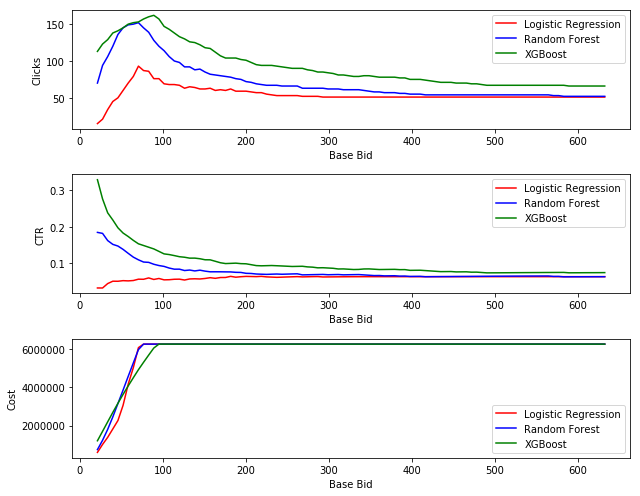

In [16]:
plt.figure(figsize = (9,7))

plt.subplot(3,1,1)
plt.plot(basebids, results.loc[results["pCTR_model"] == "Logistic Regression", "Clicks"].values, "r")
plt.plot(basebids, results.loc[results["pCTR_model"] == "Random Forest", "Clicks"].values, "b")
plt.plot(basebids, results.loc[results["pCTR_model"] == "XGBoost", "Clicks"].values, "g")

plt.xlabel("Base Bid")
plt.ylabel("Clicks")
plt.legend(pCTR_model_names)

plt.subplot(3,1,2)
plt.plot(basebids, results.loc[results["pCTR_model"] == "Logistic Regression", "CTR"].values, "r")
plt.plot(basebids, results.loc[results["pCTR_model"] == "Random Forest", "CTR"].values, "b")
plt.plot(basebids, results.loc[results["pCTR_model"] == "XGBoost", "CTR"].values, "g")

plt.xlabel("Base Bid")
plt.ylabel("CTR")
plt.legend(pCTR_model_names)

plt.subplot(3,1,3)
plt.plot(basebids, results.loc[results["pCTR_model"] == "Logistic Regression", "Cost"].values, "r")
plt.plot(basebids, results.loc[results["pCTR_model"] == "Random Forest", "Cost"].values, "b")
plt.plot(basebids, results.loc[results["pCTR_model"] == "XGBoost", "Cost"].values, "g")

plt.xlabel("Base Bid")
plt.ylabel("Cost")
plt.legend(pCTR_model_names)

plt.tight_layout()
plt.savefig("Linear_Strategy_Results.png")